# HW2: Inception network 구현
## Due: 9/27 15:30

[Inception network](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)는 Inception module 여러개로 구성된 모델이다. 다음 그림을 참고하여 Inception network를 구현하시오.

- **채점 기준**
  - Inception module을 잘 구현해야 한다.
  - 아래의 표에 있는 대로 architecture를 구현해야 한다. (논문과 약간 다르게 auxiliary classifier 등이 생략되어 있다)
  - 아래의 **표에 있는 대로 hyperparameter(filter size, stride, filter 수)를 설정**해야 하고, 각 layer 및 module의 **output size가 표와 같게 나와야 한다.**
  - test accuracy가 **65% 이상** 나와야 한다.
 
- **제출**
  - 주피터 파일 제출 (output 지우지 말아 주세요)

### Inception module

- `strides`는 모두 1로 설정해야 output size가 맞게 나올 것이다.



<img src="https://user-images.githubusercontent.com/37704174/108797724-369ef800-75cf-11eb-987a-926657daf61e.JPG" width="400" height="400"/>  



### Inception network architecture
- 아래의 표에 있는대로 구성을 하면 이러한 구조의 모델이 만들어진다.

<img src="https://user-images.githubusercontent.com/37704174/108797713-2dae2680-75cf-11eb-8593-5a1bf50549da.png" width="400" height="400"/>  

### specification


<img src="https://user-images.githubusercontent.com/37704174/109782740-8d9a7200-7c4c-11eb-9999-d859b67dc468.JPG" width="600" height="600"/>  

- 이 표에 있는 대로 위에서부터 layer 및 Inception module을 쌓아야 한다.
- 모든 `Conv2D`와 `MaxPool2D`의 padding 옵션은 `same`으로 설정해야 output size가 올바르게 나올 것이다.
- 표 3행을 보면 convolution의 depth가 2이다. 이것은 `Conv2D` layer가 2개 있다는 뜻이고, 각각의 filter의 수는 64, 192로 설정해야 한다.
- Inception module의 hyperparameter 설명
  - #1x1: 맨 왼쪽 1x1 convolution layer의 filter 수
  - #3x3 reduce: 3x3 convolution layer 이전에 나오는 1x1 convolution layer의 filter 수
  - #3x3: 3x3 convolution layer의 filter 수
  - #5x5 reduce: 5x5 convolution layer 이전에 나오는 1x1 convolution layer의 filter 수
  - #5x5: 5x5 convolution layer의 filter 수
  - pool proj: max pooling 다음에 나오는 1x1 convolution layer의 filter 수

### 사용할 모듈 import

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Flatten, Add, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
### 자유롭게 import

In [2]:
gpu_growth = True  #true로 하면 모듈 import 할 때, 한 번에 메모리 다 사용하지 않고, 순차적으로 사용함?

if gpu_growth:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass

### Inception module 구현


In [3]:
def InceptionModule(inputs, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool):
    '''
    inputs: Inception module의 인풋
    f_ : 위의 표에 나와있는 filter 수
    
    '''
    x1 = Conv2D(filters = f_1x1, kernel_size = (1,1), padding='same')(inputs)
    
    x2_1 = Conv2D(filters = f_3x3_r, kernel_size = (1,1), padding = 'same')(inputs)
    x2_2 = Conv2D(filters = f_3x3, kernel_size = (3,3), padding = 'same')(x2_1)
    
    x3_1 = Conv2D(filters = f_5x5_r , kernel_size = (1,1), padding = 'same')(inputs)
    x3_2 = Conv2D(filters = f_5x5, kernel_size = (5,5), padding = 'same')(x3_1)
    
    x4_1 = MaxPooling2D(pool_size = 2, strides=1, padding='same')(inputs)
    x4_2 = Conv2D(filters = f_pool , kernel_size = (1,1), padding = 'same')(x4_1)
    
    outputs = Concatenate(axis=-1)([x1, x2_2, x3_2, x4_2])# use tf.keras.layers.concatenate
    
    return outputs

### Inception network 구현

In [4]:
def InceptionNet():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    '''
    표에 있는 대로 모델을 만들어 주세요 
    '''
    #x = Conv2D(filters = , kernel_size = , padding= 'same')
    #x = InceptionModule(inputs = x, f_1x1 = , f_3x3_r = , f_3x3 = , f_5x5_r = , f_5x5 = , f_pool = )
    
    x = Conv2D(filters = 64 , kernel_size = (7,7), padding= 'same')(inputs)
    x = MaxPooling2D(pool_size = 3, strides=2, padding='same')(x)
    x = Conv2D(filters = 64, kernel_size = (1,1), padding= 'same')(x)
    x = Conv2D(filters = 192, kernel_size = (3,3) , padding= 'same')(x)
    x = MaxPooling2D(pool_size = 3, strides=2, padding='same')(x)
    
    x = InceptionModule(inputs = x, f_1x1 = 64, f_3x3_r = 96, f_3x3 = 128, f_5x5_r = 16, f_5x5 = 32, f_pool = 32)
    x = InceptionModule(inputs = x , f_1x1 = 128, f_3x3_r = 128, f_3x3 = 192, f_5x5_r = 32, f_5x5 = 96, f_pool = 64)
    x = MaxPooling2D(pool_size = 3, strides=2, padding='same')(x)
    
    x = InceptionModule(inputs = x, f_1x1 = 192, f_3x3_r = 96, f_3x3 = 208, f_5x5_r = 16, f_5x5 = 48, f_pool = 64)
    x = InceptionModule(inputs = x, f_1x1 = 160, f_3x3_r = 112, f_3x3 = 224, f_5x5_r = 24, f_5x5 = 64, f_pool = 64)
    x = InceptionModule(inputs = x, f_1x1 = 128, f_3x3_r = 128, f_3x3 = 256, f_5x5_r = 24, f_5x5 = 64, f_pool = 64)
    x = InceptionModule(inputs = x, f_1x1 = 112, f_3x3_r = 144, f_3x3 = 288, f_5x5_r = 32, f_5x5 = 64, f_pool = 64)
    x = InceptionModule(inputs = x, f_1x1 = 256, f_3x3_r = 160, f_3x3 = 320, f_5x5_r = 32, f_5x5 = 128, f_pool = 128)
    x = MaxPooling2D(pool_size = 3, strides=2, padding='same')(x)
    
    x = InceptionModule(inputs = x, f_1x1 = 256, f_3x3_r = 160, f_3x3 = 320, f_5x5_r = 32, f_5x5 = 128, f_pool = 128)
    x = InceptionModule(inputs = x, f_1x1 = 384, f_3x3_r = 192, f_3x3 = 384, f_5x5_r = 48, f_5x5 = 128, f_pool = 128)
    x = GlobalAveragePooling2D()(x)
    
    outputs = Dense(10, activation='softmax')(x)


    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [5]:
my_inception = InceptionNet()

### 모델 summary

아래 셀을 실행 했을 때, 표의 각각에 해당하는 output size가 맞게 나와야 한다.

In [6]:
my_inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

### training data (아래 셀 수정 금지)

아래의 데이터를 이용한다.

In [7]:
# DO NOT MODIFY

#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

170508288/170498071 [==============================] - 3s 0us/step


In [8]:
import numpy as np
np.min(x_train), np.max(x_train)

(0, 255)

### data preprocessing

원하는 대로 데이터를 전처리 해주면 된다.

In [9]:
# data preprocessing (ex normalize...)
x_train, x_valid, x_test = x_train / 255.0, x_valid / 255.0, x_test / 255.0

### model compile

optimizer, loss function을 알맞게 설정한다.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optim_fn = tf.keras.optimizers.Adam(learning_rate=0.001)

In [11]:
my_inception.compile(optimizer=optim_fn,
              loss=loss_fn,
              metrics=['accuracy'] )

### model training

hyperparameter를 적절히 설정한다. (epochs 등..)

In [12]:
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >=3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay)
]

In [13]:
hist = my_inception.fit(x=x_train, 
                        y=y_train, 
                        validation_data=(x_valid, y_valid),
                        # your hyperparameters...
                        epochs=10, callbacks=callbacks
                        )

Epoch 1/10
1407/1407 [==============================] - 143s 76ms/step - loss: 2.0488 - accuracy: 0.4209 - val_loss: 1.3611 - val_accuracy: 0.5144
Epoch 2/10
1407/1407 [==============================] - 105s 75ms/step - loss: 1.2149 - accuracy: 0.5704 - val_loss: 1.4300 - val_accuracy: 0.5138
Epoch 3/10
1407/1407 [==============================] - 106s 75ms/step - loss: 1.1429 - accuracy: 0.6042 - val_loss: 1.1116 - val_accuracy: 0.6088
Epoch 4/10
1407/1407 [==============================] - 105s 75ms/step - loss: 0.6591 - accuracy: 0.7711 - val_loss: 0.6897 - val_accuracy: 0.7674
Epoch 5/10
1407/1407 [==============================] - 105s 75ms/step - loss: 0.4969 - accuracy: 0.8267 - val_loss: 0.7094 - val_accuracy: 0.7708
Epoch 6/10
1407/1407 [==============================] - 106s 75ms/step - loss: 0.3791 - accuracy: 0.8672 - val_loss: 0.7189 - val_accuracy: 0.7742
Epoch 7/10
1407/1407 [==============================] - 105s 75ms/step - loss: 0.2673 - accuracy: 0.9055 - val_loss: 0

### 참고용

조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

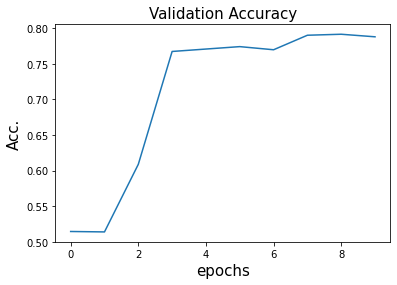

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

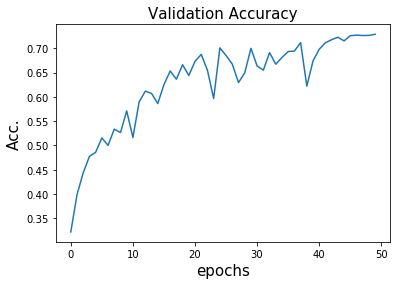

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **65% 이상**이 나와야 한다.

In [15]:
my_inception.evaluate(x_test, y_test)

313/313 [==============================] - 9s 29ms/step - loss: 1.0787 - accuracy: 0.7863


[1.078737497329712, 0.786300003528595]